# Busca de objetos em imagens na pirâmide Gaussiana

**Curso**: Processamento Digital de Imagens - UFScar 2020/2

**Alunos**:
- Leonardo Donderi Rodrigues (754756)
- Luís Felipe Corrêa Ortolan (759375)
- Marco Antonio Bernardi Grivol (758619)
- Reynold Navarro Mazo (756188)

O Objetivo desse trabalho é implementar a localização de objeto na pirâmide gaussiana de uma imagem, ou seja, realizar calcular as diferenças quadráticas em cada cada nível da pirâmidae a imagem template e identificar o menor valor de diferença entre todos os níveis.

## Importando bibliotecas e definindo funções.

In [ ]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from scipy.signal import convolve, correlate

In [ ]:
def draw_rectangle(img, center, size):
    """Draw Rectangle
    
    Função que desenha um retângulo na imagem original dado um valor para o centro e tamanho.
    
    Parâmetros
    ----------
    img : numpy array
        Imagem a ser desenhado o retângulo.
        
    center : list ou tuple com 1 linha e 2 colunas
        Centro do retângulo na imagem orignal. 
        Deve conter a linha seguida da posição, e.g., (56, 78) linha 56 e coluna 78.
        
    size : list ou tuple com 1 linha e 2 colunas
        Tamanho do retângulo a ser desenhado.
        As coordenadas representam a largura e altura respectivamente, em coordenadas da imagem original.
        Deve conter a largura seguida da altura, e.g., (56, 78) largura de 56 e altura 78.
    
    Returns
    -------
    img_rectangle : numpy array
        Cópia da imagem original com um retângulo de centro e tamanho definidos.
    """
    
    half_num_rows_obj = size[0]//2
    half_num_cols_obj = size[1]//2

    img_rectangle = img.copy()

    point1 = (center[1] - half_num_cols_obj, center[0] - half_num_rows_obj)
    point2 = (center[1] + half_num_cols_obj, center[0] + half_num_rows_obj)
    cv2.rectangle(img_rectangle, pt1 = point1, pt2 = point2, color = 255, thickness = 5)

    return img_rectangle

In [ ]:
def downsample(img):
    """Downsampling de Imagem
    
    Gera uma nova imagem com metade do tamanho da imagem de entrada. A imagem de
    entrada é suavizada utilizando um filtro gaussiano e amostrada a cada 2 pixels
       
    Parâmetros
    ----------
    img : numpy array
        Imagem a ser realizada o downsample com metade do tamanho.
        
    Returns
    -------
    img_downsample : numpy array
        Cópia da imagem original suavizada com filtro gaussiano e metade do tamanho.
    """

    # Filtro Gaussiano para suavizar a imagem
    gaussian = np.array([[1,  4,  6,  4, 1],
                       [4, 16, 24, 16, 4],
                       [6, 24, 36, 24, 6],
                       [4, 16, 24, 16, 4],
                       [1,  4,  6,  4, 1]])

    gaussian = gaussian / 256.

    img = img.astype(float)
    num_rows, num_cols = img.shape
    half_num_rows = (num_rows + 1) // 2
    half_num_cols = (num_cols + 1) // 2

    # convolução com filtro gaussiano
    img_smooth = convolve(img, gaussian, mode = 'same')

    img_downsample = np.zeros([half_num_rows, half_num_cols])
    for row in range(half_num_rows):
        for col in range(half_num_cols):
            # amostra a cada 2 pixels
            img_downsample[row, col] = img_smooth[2*row, 2*col]

    return img_downsample

In [ ]:
def build_gaussian_pyramid(img, size):
    """Build Gaussian Pyramid
    
    Contrói uma pirâmide gaussiana e armazena cara nível em uma lista.
    
    Parâmetros
    ----------
    img : numpy array
        Imagem original a ser contruída a pirâmide.
        
    size : int
        Quantidade de níveis na pirâmide.
        
    Returns
    -------
    pyramid : list
        Lista contendo todos os níveis da pirâmide gaussiana.
    """
    
    pyramid = [img]

    img_down = img
    for level in range(size-1):
        # adiciona uma imagem com downsample para cada nível
        img_down = downsample(img_down)
        pyramid.append(img_down)

    return pyramid

In [ ]:
def quadratic_difference(img, obj):
    """Quadratic Difference
    
    Calcula a diferença quadrática entre as imagens img e obj utilizando correlação-cruzada.
    
    Parâmetros
    ----------
    img : numpy array
        Imagem orignal a ser procurado o objeto.
    
    obj : numpy array
        Imagem do objeto a ser procurado na imagem original.
        
    Returns
    -------
    img_diff : numpy array
        Cópia da imagem original com valores de intensidade indicando a diferença quadrática calculada.
        O menor valor representa o possível centro do objeto na imagem.
    """

    w = np.ones(obj.shape)
    imgOw = correlate(img**2, w, mode = 'same')
    imgOobj = correlate(img, obj, mode = 'same')

    img_diff = imgOw + np.sum(obj**2) - 2 * imgOobj

    return img_diff

In [ ]:
def find_minimum(img):
    """Find Minimum
    
    Função que encontra o menor valor e sua posição na imagem dada.
       
    Parâmetros
    ----------
    img : numpy array
        Imagem a ser encontrado o menor valor e sua posição.
        
    Returns
    -------
    minimum_value, index_minimum_value : tuple
        minimum_value : numpy float64
            O menor valor de intensidade na imagem.
        index_minimum_value : tuple
            A posição em linhas e colunas do menor valor.
    """

    num_rows, num_cols = img.shape
    minimum_value = img[0,0]
    index_minimum_value = (0,0)

    for row in range(num_rows):
        for col in range(num_cols):
            if img[row, col] < minimum_value:
                # valor mínimo encontrado
                minimum_value = img[row,col]
                index_minimum_value = (row, col)

    return minimum_value, index_minimum_value


In [ ]:
def find_pyramid(img, obj, levels=5):
    """Find Pyramid
    
    Gera uma pirâmide gaussiana para a imagem original e em seguida calcula a diferença
    quadrática entre a imagem e o objeto para cada nível da pirâmide.
       
    Parâmetros
    ----------
    img : numpy array
        Imagem global que será feita a pirâmide gaussiana e localizado o objeto.
        
    obj : numpy array
        Imagem do objeto a ser localizado na imagem através de diferenças quadráticas.
        
    levels : int, default = 5
        Quantidade de níveis na pirâmide gaussina.
        
    Returns
    -------
    imgs, minimum_value, index_minimum_value : tuple
        imgs : list
            Lista contendo a imagem original com um retângulo com centro no menor
            valor encontrado pela diferença quadrática em cada nível da pirâmide.
        minimum_value : numpy float64
            O menor valor de intensidade na imagem.
        index_minimum_value : tuple
            A posição em linhas e colunas do menor valor.
    """
    
    pyramid = build_gaussian_pyramid(img, levels)
    print(f'Níveis da pirâmide = {levels}')

    global_minimum = sys.maxsize
    index_global_minimum = -1
    i = 0
    imgs = []

    for level in pyramid:
        # calcula a diferença quadrática para cada nível da pirâmide
        img_diff = quadratic_difference(level, obj)
        # encontra o valor e posição de menor intensidade
        minimum_value, index_minimum_value = find_minimum(img_diff)
        # desenha o retângulo
        img_rectangle = draw_rectangle(level, index_minimum_value, obj.shape)
        imgs.append(img_rectangle)

        if (minimum_value < global_minimum):
            # novo valor mínimo encontra
            global_minimum = minimum_value
            index_global_minimum = i

    i = i + 1

    global_minimum = global_minimum.astype(int)

    return imgs, global_minimum, index_global_minimum

## Localização do Objeto em Cinco Escalas

Níveis da pirâmide = 5
Mínimo Global:  40844301  na imagem número  1


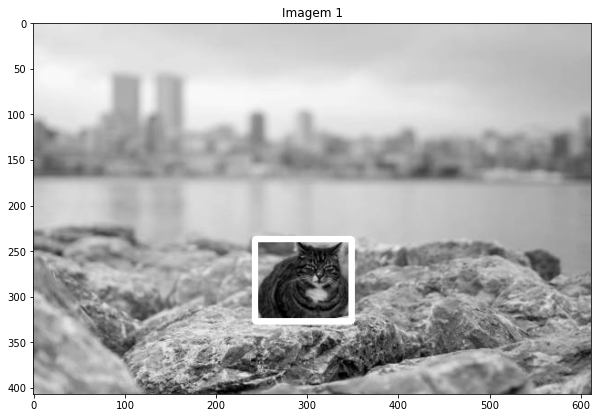

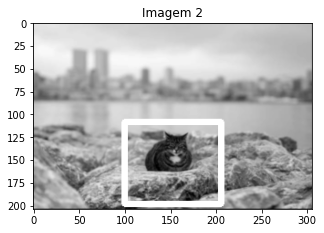

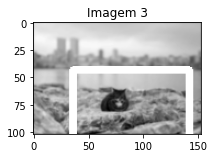

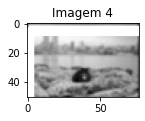

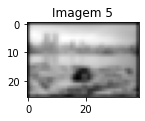

In [ ]:
img = plt.imread('imagem_global.png')
img = np.round(255 * img).astype(float) # usar isso caso .png
# img = img.astype(float)                 # usar isso caso .tiff
obj = plt.imread('gato.png')
obj = np.round(255 * obj).astype(float) # usar isso caso .png
# obj = obj.astype(float)                 # usar isso caso .tiff

imgs, global_minimum, index_global_minimum = find_pyramid(img, obj)

for i in range(len(imgs)):
    # exibe uma imagem para cada nível da pirâmide com um retângulo no centro 
    # do menor valor para a diferença quadrática entre a imagem e o objeto
    fig = plt.figure(figsize = (20//(2*(i+1)), 20//(2*(i+1))))
    plt.title(f'Imagem {i + 1}')
    plt.imshow(imgs[i], 'gray')

print("Mínimo Global: ", global_minimum, " na imagem número ", index_global_minimum + 1)